In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Inplace of "/content/drive/MyDrive/archive.zip", write the directory in which your data is present
! cp "/content/drive/MyDrive/archive.zip" "/content/"

In [ ]:
! unzip archive.zip -d /content/captcha

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras.utils import load_img
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
import string

In [8]:
root = "/content/captcha/"

In [12]:
#total no of images in dataset
n=len(os.listdir(root))
print("Total no. of images:",n)
print(os.listdir(root)[0])

#defining size of image
imgshape=(40 , 150 ,1) #40-height, 150-width, 1-no of channels


Total no. of images: 113062
tRn9U.jpg


In [13]:
count = 0
for i in os.listdir(root):
  if('.jpg' in  i):
      count += 1
count

113062

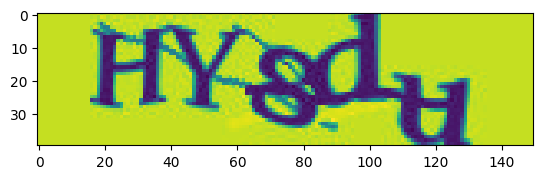

In [14]:
img = load_img(os.path.join(root, "HY8du.jpg"), color_mode="grayscale", target_size=(40,150))
plt.imshow(img)
img = np.array(img, dtype = float).reshape(40 , 150 , 1)
img /= 255.0
# print(img)

In [15]:
dataset = np.zeros((n,40,150,1))

root_lst = os.listdir(root)

for i in range(len(root_lst)):
  img = load_img(os.path.join(root,root_lst[i]), color_mode="grayscale", target_size=(40,150))
  img = np.array(img, dtype = float).reshape(40 , 150 , 1)
  img = img/255.0

  dataset[i] = img


  #Printing progress after loading every 10,000 images
  if (i%10000 == 0):
    print(i)

  #Breaking the loop after loading 80,000 images
  if (i == 80000):
    break

dataset[0]

0
10000
20000
30000
40000
50000
60000
70000
80000


array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.00784314],
        [0.01176471],
        [0.00784314]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.00392157],
        [0.00392157],
        [0.00784314]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.01568627],
        [0.00784314],
        [0.00784314]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [16]:
img_label = [name.split('.')[0] for name in root_lst]
img_label[:10]

['tRn9U',
 'SfJkS',
 'pHsfW',
 'P5IsG',
 'sBWVf',
 'JjcWQ',
 'hli4B',
 'sBiHe',
 'krxPI',
 '5yMKf']

In [17]:
character= string.ascii_lowercase + string.ascii_uppercase + "0123456789" # All symbols captcha can contain
nchar = len(character) #total number of char possible
nchar

62

In [18]:
y = np.zeros((5,n,nchar))
for i , img in enumerate(img_label):
  target = np.zeros((5 , nchar))
  for j , k in enumerate(img):
    index = character.find(k)
    target[j , index] = 1
  y[:,i] = target

In [19]:
print(img_label[0])
print(y[0])


tRn9U
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


Completed Preprocessing!

In [28]:
def createmodel():
    img = layers.Input(shape=imgshape) # Get image as an input of size 40 , 150 ,1
    rot = layers.RandomRotation(0.05, fill_mode = "nearest")(img)
    trans = layers.RandomTranslation(0.1,0.1, fill_mode = "nearest")(rot)
    zoom = layers.RandomZoom(height_factor = 0.05, width_factor = 0.1, fill_mode = "nearest")(trans)

    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(zoom)
    bn1 = layers.BatchNormalization()(conv1) #to improve the stability of model
    mp1 = layers.MaxPooling2D(padding='same')(bn1)

    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    conv21 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(conv2)
    bn2 = layers.BatchNormalization()(conv21)
    mp2 = layers.MaxPooling2D(padding='same')(bn2)


    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3) #to improve the stability of model
    mp3 = layers.MaxPooling2D(padding='same')(bn)

    conv4 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(mp3)
    conv41 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(conv4)
    bn1 = layers.BatchNormalization()(conv41) #to improve the stability of model
    mp4 = layers.MaxPooling2D(padding='same')(bn1)

    conv5 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(mp4)
    bn2 = layers.BatchNormalization()(conv5) #to improve the stability of model
    mp5 = layers.MaxPooling2D(padding='same')(bn2)

    flat = layers.Flatten()(mp5) #convert the layer into 1-D

    outs = []
    for _ in range(5): #for 5 letters of captcha
        dens1 = layers.Dense(128, activation='relu')(flat)
        drop = layers.Dropout(0.2)(dens1) #drops 0.2 fraction of nodes
        res = layers.Dense(nchar, activation='softmax')(drop)

        outs.append(res) #result of layers

    # Compile model and return it
    model = Model(img, outs) #create model
    model.compile(loss= "categorical_crossentropy", optimizer='RMSprop',metrics=["accuracy"])
    return model

In [29]:
model=createmodel()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 40, 150, 1)]         0         []                            
                                                                                                  
 random_rotation_3 (RandomR  (None, 40, 150, 1)           0         ['input_4[0][0]']             
 otation)                                                                                         
                                                                                                  
 random_translation_3 (Rand  (None, 40, 150, 1)           0         ['random_rotation_3[0][0]']   
 omTranslation)                                                                                   
                                                                                            

In [30]:
x_train = dataset[:60000]
y_train = y[:,:60000]

x_validate = dataset[60000: 61000]
y_validate = y[:,60000:61000]



In [31]:
hist = model.fit(x_train , [y_train[0], y_train[1], y_train[2], y_train[3] ,y_train[4]] , batch_size = 3000, epochs=120 , validation_data= (x_validate , [y_validate[0], y_validate[1], y_validate[2], y_validate[3] ,y_validate[4]]))

Epoch 1/120
20/20 [==============================] - 39s 688ms/step - loss: 21.1191 - dense_31_loss: 4.2347 - dense_33_loss: 4.2044 - dense_35_loss: 4.2250 - dense_37_loss: 4.2460 - dense_39_loss: 4.2089 - dense_31_accuracy: 0.0179 - dense_33_accuracy: 0.0168 - dense_35_accuracy: 0.0176 - dense_37_accuracy: 0.0171 - dense_39_accuracy: 0.0180 - val_loss: 20.6654 - val_dense_31_loss: 4.1315 - val_dense_33_loss: 4.1362 - val_dense_35_loss: 4.1294 - val_dense_37_loss: 4.1350 - val_dense_39_loss: 4.1334 - val_dense_31_accuracy: 0.0200 - val_dense_33_accuracy: 0.0190 - val_dense_35_accuracy: 0.0150 - val_dense_37_accuracy: 0.0130 - val_dense_39_accuracy: 0.0160
Epoch 2/120
20/20 [==============================] - 11s 533ms/step - loss: 20.6239 - dense_31_loss: 4.1230 - dense_33_loss: 4.1259 - dense_35_loss: 4.1244 - dense_37_loss: 4.1265 - dense_39_loss: 4.1241 - dense_31_accuracy: 0.0178 - dense_33_accuracy: 0.0171 - dense_35_accuracy: 0.0193 - dense_37_accuracy: 0.0174 - dense_39_accuracy:

In [32]:
model.evaluate(x_test , [y_test[0], y_test[1], y_test[2], y_test[3] ,y_test[4]])

63/63 [==============================] - 1s 15ms/step - loss: 2.7891 - dense_31_loss: 0.3929 - dense_33_loss: 0.6128 - dense_35_loss: 0.7506 - dense_37_loss: 0.6318 - dense_39_loss: 0.4011 - dense_31_accuracy: 0.8480 - dense_33_accuracy: 0.7835 - dense_35_accuracy: 0.7570 - dense_37_accuracy: 0.7865 - dense_39_accuracy: 0.8410


[2.7890889644622803,
 0.39289748668670654,
 0.6127527356147766,
 0.7505549788475037,
 0.6318172216415405,
 0.40106654167175293,
 0.8479999899864197,
 0.7835000157356262,
 0.7570000290870667,
 0.7864999771118164,
 0.8410000205039978]

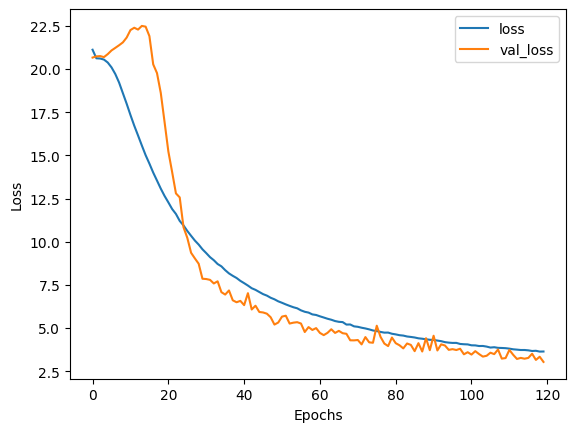

In [33]:
for label in ["loss","val_loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [34]:
x_test = dataset[61000:80000]
y_test = y[:,61000:80000]

1/1 [==============================] - 1s 585ms/step


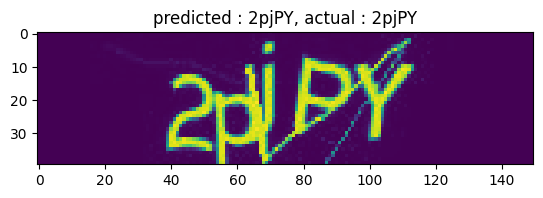

1/1 [==============================] - 0s 17ms/step


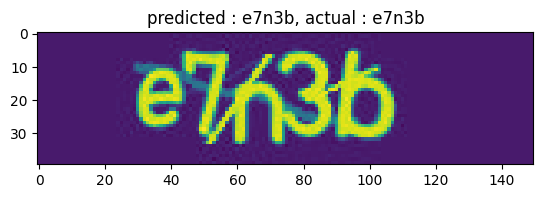

1/1 [==============================] - 0s 17ms/step


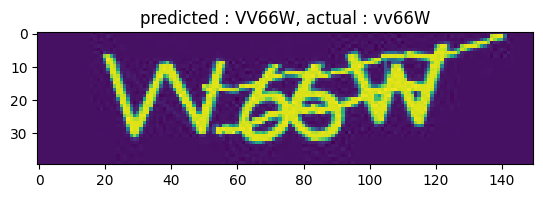

1/1 [==============================] - 0s 18ms/step


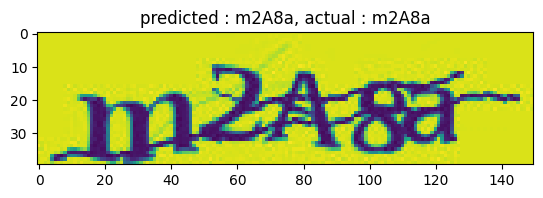

1/1 [==============================] - 0s 18ms/step


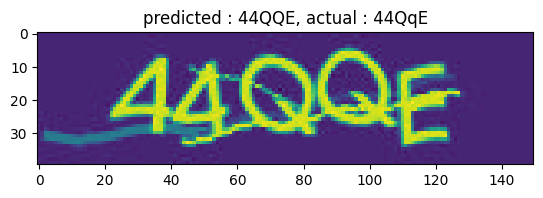

1/1 [==============================] - 0s 17ms/step


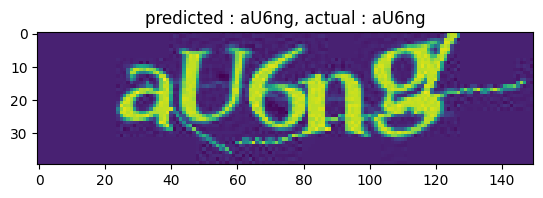

1/1 [==============================] - 0s 18ms/step


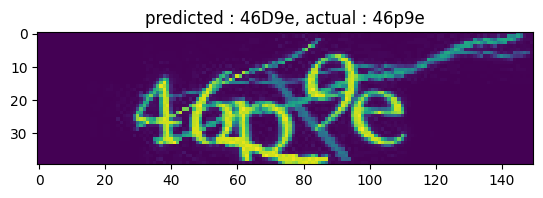

1/1 [==============================] - 0s 18ms/step


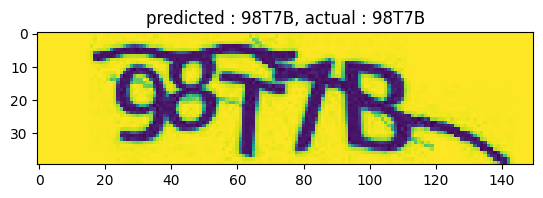

1/1 [==============================] - 0s 18ms/step


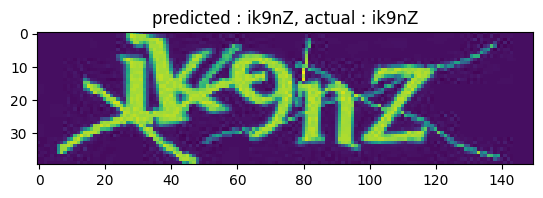

1/1 [==============================] - 0s 17ms/step


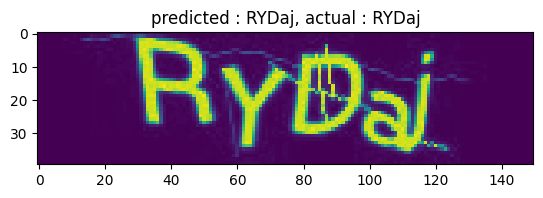

In [35]:
a = x_test[:10]
b = y_test[:,:10]

# print(b.shape)

for j in range(len(a)):
  img_ = np.expand_dims(a[j], axis = 0)
  prediction = model.predict(img_)
  pred = ""
  ans = ""
  for i in range(5):
    p = prediction[i]
    idx = np.argmax(p)
    pred += character[idx]

    ans += character[np.argmax(b[i][j])]

  plt.imshow(a[j])
  plt.title(f'predicted : {pred}, actual : {ans}')
  plt.show()

In [36]:
a = x_test
b = y_test


predictions = np.array(model.predict(a, verbose=0))

right = 0
wrong = 0
for j in range(len(a)):
  img_ = np.expand_dims(a[j], axis = 0)
  prediction = predictions[:,j:j+1]
  pred = ""
  ans = ""
  for i in range(5):
    p = prediction[i]
    idx = np.argmax(p)
    pred += character[idx]

    ans += character[np.argmax(b[i][j])]

  if (pred == ans):
    right += 1
  else:
    wrong += 1

print(right, wrong, right + wrong)

print(f"actual accuracy : {round(right*100/(right + wrong),2)}%")

7507 11493 19000
actual accuracy : 39.51%
